In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from src.classes import BallAnomaly, Boundary
from src.util import plot_voxel, plot_voxel_c, voxel_ball

boundary = Boundary()

# Stage 1

Build the variational autoencoder to learn a latent representation of the domain $\Omega \in \mathbb{R}^3$.

Object radius

- 40mm $\rightarrow$ `r= 5`
- 30mm $\rightarrow$ `r= 4`
- 20mm $\rightarrow$ `r= 3`

Material

- acrylic $\rightarrow$ $\gamma$ = 0
- brass $\rightarrow$ $\gamma$ = 1

Literature

- [Variational Autoencoder (VAE) with Discrete Distribution using Gumbel Softmax](https://towardsdatascience.com/variational-autoencoder-vae-with-discrete-distribution-using-gumbel-softmax-b3f749b3417e)

- [Tutorial: Categorical Variational Autoencoders using Gumbel-Softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html)

- [Categorical Reparameterization with Gumbel-Softmax](https://github.com/EderSantana/gumbel)
    - [GitHub Categorical Reparameterization with Gumbel-Softmax](https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb)


- [CAT VAE](https://github.com/flatironinstitute/catvae)

In [2]:
ball = BallAnomaly(x=10, y=10, z=10, r=5, γ=1)

In [3]:
ball_vxl = voxel_ball(ball, boundary)

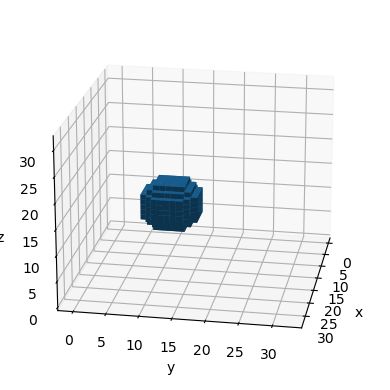

In [4]:
plot_voxel(ball_vxl)

In [5]:
X_all_anomalys = list()
radius_labels = list()

γ = 1 # set object geometries to 1 and empty space to 0
for r in [3, 4, 5]:  # radius
    for x in np.arange(boundary.x_0 + ball.r, boundary.x_length - ball.r, 1):
        for y in np.arange(boundary.y_0 + ball.r, boundary.y_length - ball.r, 1):
            for z in np.arange(boundary.z_0 + ball.r, boundary.z_length - ball.r, 1):
                ball = BallAnomaly(x, y, z, r, γ)
                X_all_anomalys.append(voxel_ball(ball, boundary))
                radius_labels.append(r)

X_all_anomalys = np.array(X_all_anomalys)
radius_labels = np.array(radius_labels)

In [6]:
print(X_all_anomalys.shape, radius_labels.shape)

(41452, 32, 32, 32) (41452,)


In [7]:
X_train, X_test, d_train,d_test = train_test_split(
    X_all_anomalys, radius_labels, train_size=0.95
)

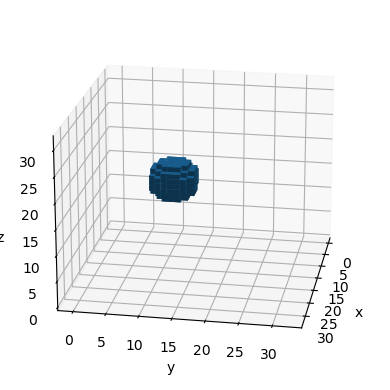

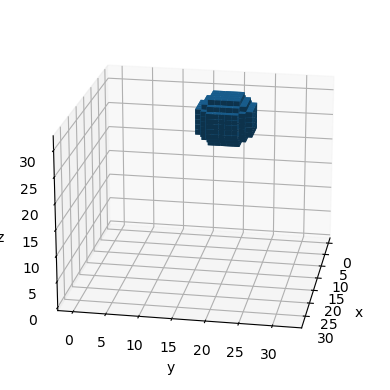

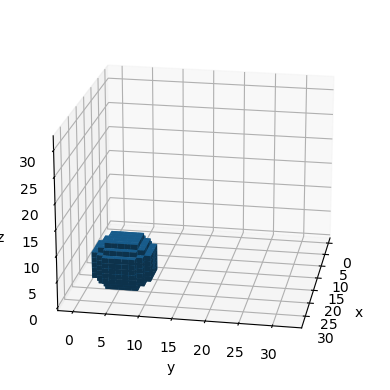

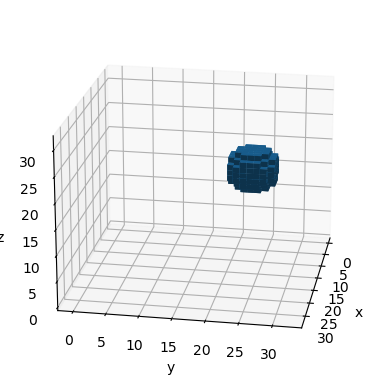

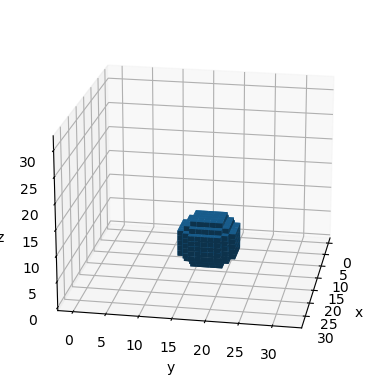

In [8]:
for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    plot_voxel_c(X_train[rdn, ...])

In [9]:
from tensorflow.keras.optimizers import Adam
from src.vae import vae_model

2024-04-04 13:46:35.730344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 13:46:35.730421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 13:46:35.763250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 13:46:35.820508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 13:46:38.807942: W tensorflow/compiler/tf2

In [10]:
vae = vae_model(input_shape=(32, 32, 32, 1), beta=0.4)

# learning_rate = 0.0001
#sgd = SGD(learning_rate = learning_rate_1, momentum = 0.9, nesterov = True)
#vae.compile(optimizer = SGD())# , metrics = ['accuracy']
vae.compile(optimizer=Adam())# learning_rate = learning_rate

epochs = 150
batch_size = 100

#cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=47)

history = vae.fit(
    np.expand_dims(X_train, 4),
    epochs=epochs,
    batch_size=batch_size,
    #callbacks=[cb],
)

2024-04-04 13:46:45.612400: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/150
189/394 [=============>................] - ETA: 2:47 - loss: 1650.3552 - reconstruction_loss: 1548.8910 - kl_loss: 4.7940 - total_loss: 1550.8097


KeyboardInterrupt



In [ ]:
vae.save_weights('models/vae.weights.h5')

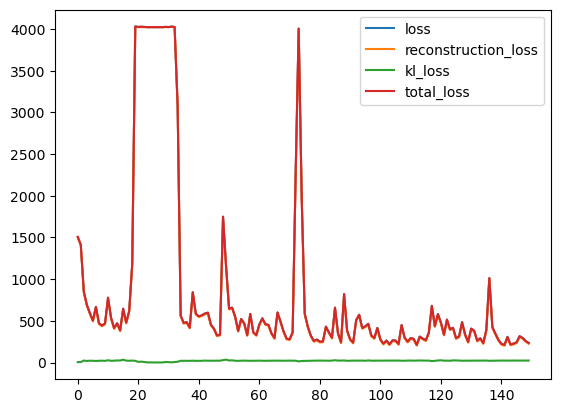

In [30]:
for keys in history.history.keys():
    plt.plot(history.history[keys], label=keys)
    plt.legend()
plt.show()

In [31]:
# Encode test set into latent space
μ, _, z = vae.encoder.predict(X_test)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(μ)

130/130 [==============================] - 1s 5ms/step


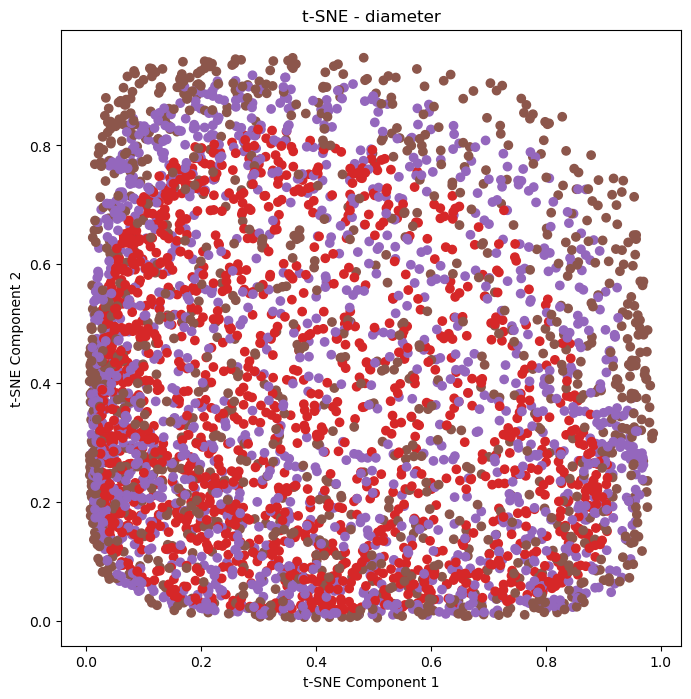

In [44]:
# Plot t-SNE embedding
plt.figure(figsize=(8, 8))
#plt.scatter(z_tsne[:,0], z_tsne[:,1], c = [f"C{c}" for c in d_test])
plt.scatter(μ[:,0], μ[:,1], c = [f"C{c}" for c in d_test])
plt.title("t-SNE - radius")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [33]:
y = vae.decoder.predict(z)

130/130 [==============================] - 0s 2ms/step


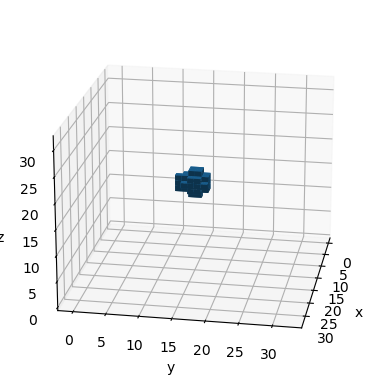

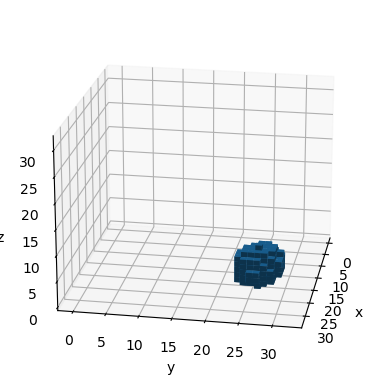

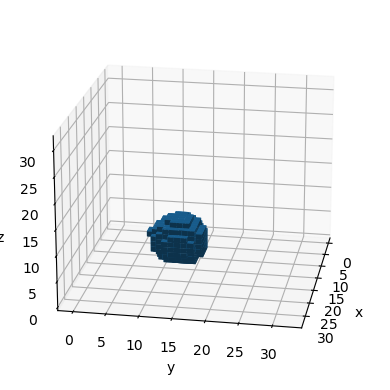

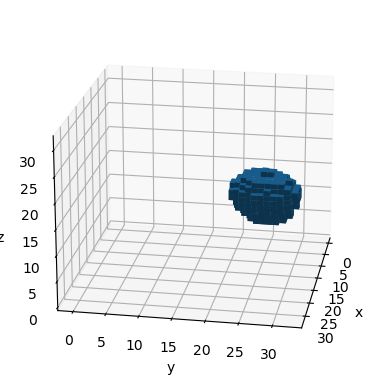

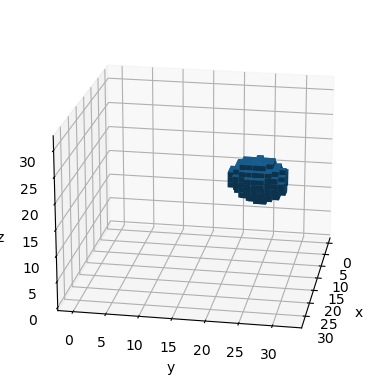

In [40]:
# y = vae.decoder.predict(np.expand_dims(np.random.rand(latent_dim), 0))
for i in np.random.randint(0,y.shape[0], 5):
    plot_voxel(np.round(y[i, :, :, :, 0]))